In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, get_file

In [2]:
dataset_link = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip"
get_file(origin=dataset_link, extract=True)

6229496702/6229496702 [==============================] - 108s 0us/step


'/root/.keras/datasets/ISIC-2017_Training_Data.zip'

In [3]:
dataset_link = "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip"
get_file(origin=dataset_link, extract=True)

9321981/9321981 [==============================] - 0s 0us/step


'/root/.keras/datasets/ISIC-2017_Training_Part1_GroundTruth.zip'

In [4]:
dset_path = "/root/.keras/datasets/ISIC-2017_Training_Data"
mask_path = "/root/.keras/datasets/ISIC-2017_Training_Part1_GroundTruth"

In [6]:
class Dataloader:
    def __init__(self, img_folder, mask_folder, IMG_WIDTH=256, IMG_HEIGHT=256, split=0.7):
            self.IMG_WIDTH = IMG_WIDTH
            self.IMG_HEIGHT = IMG_HEIGHT
            self.img_folder = img_folder
            self.mask_folder = mask_folder
            self.split = split

    def load_image_path(self):
        input_img_paths = sorted(
            [
                os.path.join(self.img_folder, fname)
                for fname in os.listdir(self.img_folder)
                if fname.endswith(".jpg")
            ]
        )
        target_img_paths = sorted(
            [
                os.path.join(self.mask_folder, fname)
                for fname in os.listdir(self.mask_folder)
                if fname.endswith(".png")
            ]
        )
        return input_img_paths, target_img_paths

    def process_image(self, img_paths, mask_paths):
        X = np.zeros((len(img_paths), self.IMG_WIDTH, self.IMG_HEIGHT, 3), dtype=np.float32)
        Y = np.zeros((len(mask_paths), self.IMG_WIDTH, self.IMG_HEIGHT, 1), dtype=np.float32)

        for i in range(len(img_paths)):
            img = img_paths[i]
            img = load_img(img, color_mode="rgb", target_size=(self.IMG_WIDTH, self.IMG_HEIGHT)) 
            img = img_to_array(img)
            X[i] = img.astype('float32') / 255.0
            
            mask = mask_paths[i]
            mask = load_img(mask, color_mode="grayscale", target_size=(self.IMG_WIDTH, self.IMG_HEIGHT))
            mask = img_to_array(mask)
            Y[i] = mask.astype('float32') / 255
        return X,Y

    def split_data(self, img_paths, X, Y):
        train_test_split = int(len(img_paths)*self.split)
        val_split = int(len(img_paths)*(self.split + (1-self.split)/2))
        X_train = X[:train_test_split]
        Y_train = Y[:train_test_split]
        X_test = X[train_test_split:val_split]
        Y_test = Y[train_test_split:val_split]
        X_val = X[val_split:]
        Y_val = Y[val_split:]
        return X_train, Y_train, X_test, Y_test, X_val, Y_val

    def get_XY_split(self):
        img_paths, mask_paths = self.load_image_path()
        X,Y = self.process_image(img_paths, mask_paths)
        X_train, Y_train, X_test, Y_test, X_val, Y_val = self.split_data(img_paths, X,Y)
        return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [7]:
DL = Dataloader(dset_path, mask_path)
X_train, Y_train, X_test, Y_test, X_val, Y_val = DL.get_XY_split()

551


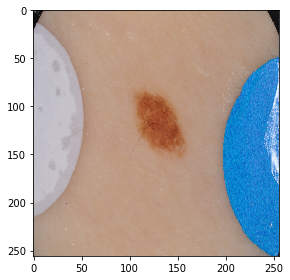

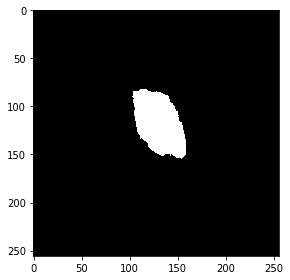

In [8]:
import random
from skimage.io import imshow
import matplotlib.pyplot as plt 
# cmap="gray"
i = random.randint(0, len(X_train))
print(i)
imshow(X_train[i])
plt.show()
imshow(np.squeeze(Y_train[i]))
plt.show()

In [55]:
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Conv2DTranspose, Concatenate
from keras.layers import Activation, SeparableConv2D, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.pooling import MaxPooling2D


def Unet():
  
    inputs = Input((256,256,3))

    """ Encoder """
    s1, x1 = contraction(inputs, 64)
    s2, x2 = contraction(x1, 128)
    s3, x3 = contraction(x2, 256)
    s4, x4 = contraction(x3, 512)

    """ Bridge """
    x5 = conv_block(x4, 1024)

    """ Decoder """
    x6 = expansion(x5, s4, 512)
    x7 = expansion(x6, s3, 256)
    x8 = expansion(x7, s2, 128)
    x9 = expansion(x8, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x9)

    """ Model """
    model = Model(inputs, outputs)
    return model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def contraction(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def expansion(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x
    

In [56]:
import tensorflow.keras.backend as K 

def diceCoefficient(y_true, y_pred):

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    # Get the pixel intersection of the two images 
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    
    # DSC = (2 * intersection) / total_pixels
    diceCoeff = (2. * intersection + 1.) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.)
    
    return diceCoeff
    
    
def diceLoss(y_true, y_pred):
  
    return 1 - diceCoefficient(y_true, y_pred)

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model = Unet()
model.compile(optimizer=Adam(), loss=diceLoss, metrics=["accuracy", diceCoefficient])

results = model.fit(X_train, Y_train, batch_size=16, epochs=25,validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/25
88/88 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8478 - diceCoefficient: 0.6559
Epoch 1: val_loss improved from inf to 0.66266, saving model to model-tgs-salt.h5
88/88 [==============================] - 15s 146ms/step - loss: 0.3452 - accuracy: 0.8478 - diceCoefficient: 0.6559 - val_loss: 0.6627 - val_accuracy: 0.2210 - val_diceCoefficient: 0.3405 - lr: 0.0010
Epoch 2/25
88/88 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8921 - diceCoefficient: 0.7381
Epoch 2: val_loss improved from 0.66266 to 0.56947, saving model to model-tgs-salt.h5
88/88 [==============================] - 12s 139ms/step - loss: 0.2623 - accuracy: 0.8921 - diceCoefficient: 0.7381 - val_loss: 0.5695 - val_accuracy: 0.5373 - val_diceCoefficient: 0.4342 - lr: 0.0010
Epoch 3/25
88/88 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9081 - diceCoefficient: 0.7742
Epoch 3: val_loss improved from 0.56947 to 0.25431, saving model to mo

10/10 [==============================] - 1s 67ms/step
Dice Coefficient 0.7014097571372986


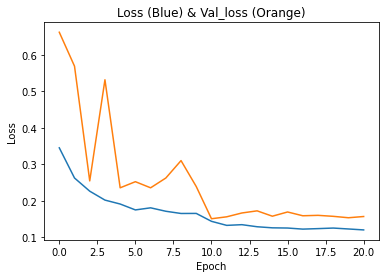

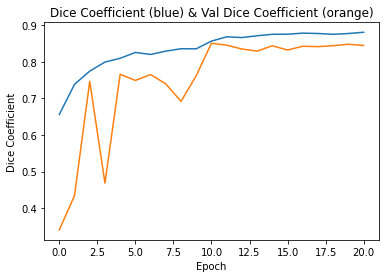

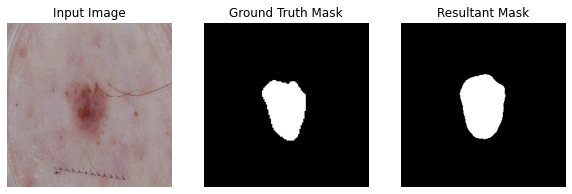

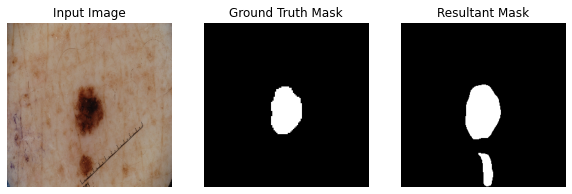

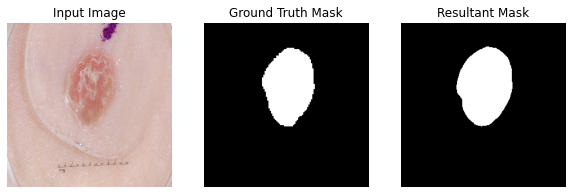

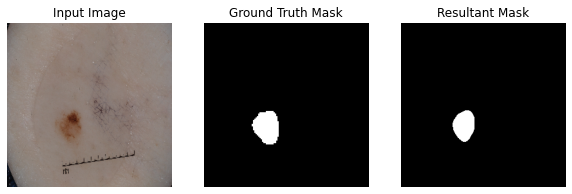

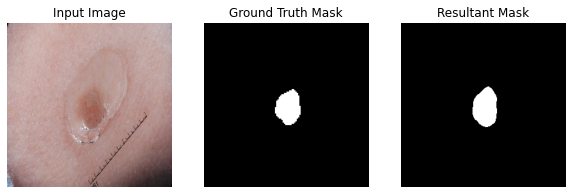

In [71]:

eval = model.evaluate(X_test, Y_test, batch_size=128)
mask_prediction = model.predict(X_test)

print("Dice Coefficient", eval[2])

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title("Loss (Blue) & Val_loss (Orange)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(results.history['diceCoefficient'])
plt.plot(results.history['val_diceCoefficient'])
plt.title("Dice Coefficient (blue) & Val Dice Coefficient (orange)")
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.show()

# Plot the original image, ground truth and result from the network.
for i in range(20,25):
    
    plt.figure(figsize=(10,10))
    
    # Plot the test image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Input Image")
    plt.axis("off")
    
    # Plot the test mask
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(Y_test[i]), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Plot the resultant mask
    plt.subplot(1, 3, 3)
    
    # Display 0 or 1 for classes
    prediction = tf.where(np.squeeze(mask_prediction[i]) > 0.5, 1.0, 0.0)
    plt.imshow(prediction, cmap='gray')
    plt.title("Resultant Mask")
    plt.axis("off")
    
    plt.show()